# **hw2_face_detection_1914022_양희원**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
# 라이브러리 불러오기기
import numpy as np
import pandas as pd
import cv2
import dlib
import matplotlib as mlp
import matplotlib.pyplot as plt
import os
from os.path import join
from glob import glob

!pip install numpy pandas opencv-python face-recognition dlib
!git clone https://github.com/ageitgey/face_recognition.git
import face_recognition
from tqdm.notebook import tqdm

plt.rcParams['figure.figsize'] = (8, 8)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=400cae45fb5c1d605825dbc484f54dcc43bf8365fef493527100d03f4000fd51
  Stored in directory: /root/.cache/pip/wheels/22/a8/60/4a2aeb763d63f50190f4c4e07069a22245347eeafdb3a67551
Successfully built face-recognition-models
Cloning into 'face_recognition'...
remote: Enumerating objects: 1028, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 1028 (delta 5), reused 6 (delta 1), pack-reused 1014
Receiving objects: 100% (1028/1028), 101.51 MiB | 13.03 MiB/s, done.
Resolving deltas: 100% (586/586), done.


# **1. Detecting**
 


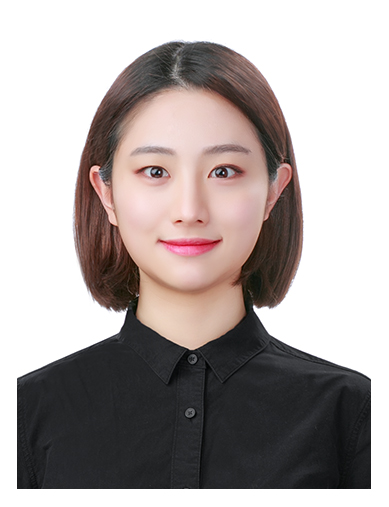
##제출한 이미지를 사용하여 Detector 성능 확인

# 1-1) Dlib detector를 이용한 얼굴 범위 검출

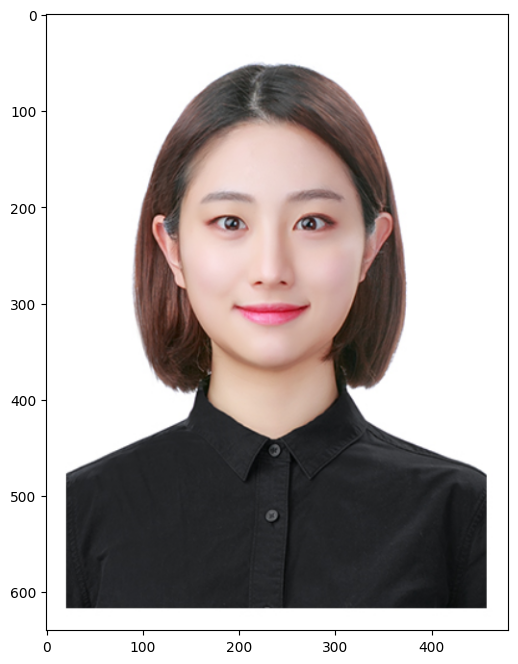

In [3]:
bgr_img0 = cv2.imread('/root/images/test_img0.jpg')
bgr_img0 = cv2.resize(bgr_img0, (480, 640))
show_img0 = cv2.cvtColor(bgr_img0.copy(), cv2.COLOR_BGR2RGB)  #출력용 이미지 복사
plt.imshow(show_img0)

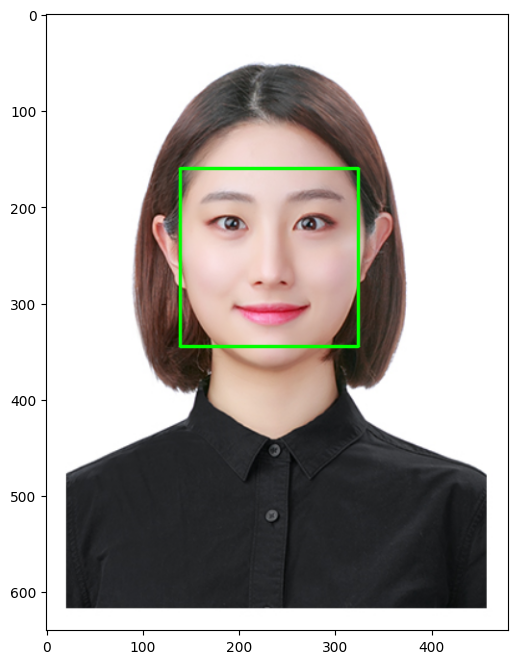

In [4]:
# dlib의 hog detector 선언 
detector_hog = dlib.get_frontal_face_detector()
rgb_img0 = cv2.cvtColor(bgr_img0, cv2.COLOR_BGR2RGB)

# 얼굴의 bounding box 추출
# detector_hog(이미지, 이미지 피라미드 수)
dlib_rects = detector_hog(rgb_img0, 1) 
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(rgb_img0, (l, t), (r, b), (0, 255, 0), 2, lineType = cv2.LINE_AA)
    # img, 좌표, 좌표, color, 선 두께, Antialliacing

plt.imshow(rgb_img0)
plt.show()


제출한 이미지에서 성공적으로 얼굴이 검출되었다

# 1-2) Hsv color 값을 이용한 HSVSegMask 구현하여 얼굴 범위 검출




In [5]:
def HSVSegMask(img):
    # 이미지 읽어오기
    # img = cv2.imread(img)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2HSV) 

    # 피부 색을 검출할 hsv 값 범위 지정
    lower = np.array([112, 10, 175], dtype="uint8")
    upper = np.array([150, 50, 250], dtype="uint8")

    # 피부색 검출을 위한 마스크 생성
    face_mask = cv2.inRange(hsv_img, lower, upper)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)) 
    face_mask = cv2.erode(face_mask, kernel, iterations = 2)
    face_mask = cv2.dilate(face_mask, kernel, iterations = 8)
    skinMask = cv2.GaussianBlur(face_mask, (3, 3), 0)

    # 외곽선 및 그 좌표 검출 -> bounding box
    contours, hierarchy = cv2.findContours(skinMask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        rect = cv2.boundingRect(contour)
        xmin, ymin, width, height = rect

    # 원본 이미지에 얼굴 범위 bounding box 표시 
    cv2.rectangle(rgb_img, (xmin, ymin), (xmin + width, ymin + height), (0, 255, 0), 2)
    return [rgb_img, xmin, ymin, width, height]


---
HSVSegMask에서 얼굴 영역이 검출되는 과정을 잠깐 살펴보면,,

먼저, 입력받은 bgr 이미지를 rgb -> hsv로 변환해준다

    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2HSV) 

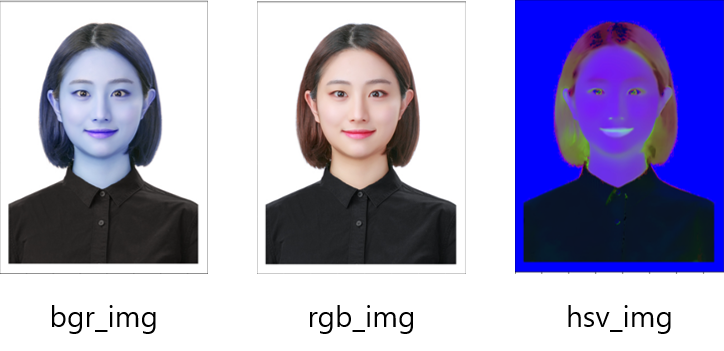

그리고 얼굴 영역에 해당하는 색상 범위를 지정해주고, 이 범위에 해당하는 마스크를 생성하면

    lower = np.array([112, 10, 175], dtype="uint8")
    upper = np.array([150, 50, 250], dtype="uint8")
    face_mask = cv2.inRange(hsv_img, lower, upper)

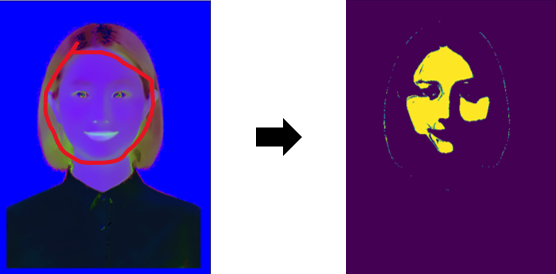

해당하는 범위의 색이 노란색으로, 해당하지 않는 범위의 색이 보라색으로 변환되어 마스크가 만들어진다.

지금의 마스크는 얼굴 영역만 검출되었다고 하기엔,, 지저분한 부분들이 있으므로 모폴로지 연산을 수행해주어 얼굴 범위 영역만 남긴다.
이때 외곽선 추출까지 같이 해준다(정말 자세히 보면 푸른 빛 외곽선이 그려져있다

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)) 
    face_mask = cv2.erode(face_mask, kernel, iterations = 2)
    face_mask = cv2.dilate(face_mask, kernel, iterations = 8)
    skinMask = cv2.GaussianBlur(face_mask, (3, 3), 0)


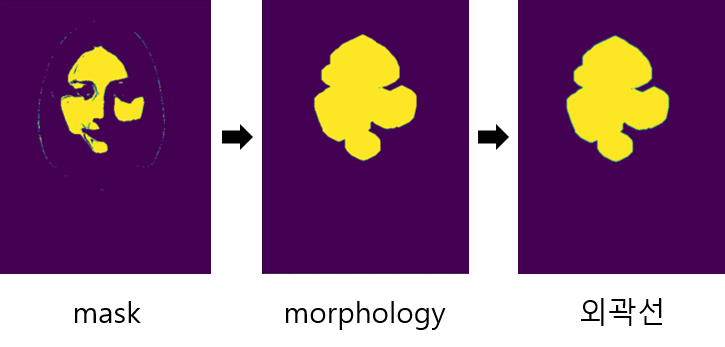

사실,, 지금의 Mask도 얼굴 영역만 검출되었다고 하기엔 외곽선이 지저분하긴 하지만 

여기서 iteration 값을 더 높이게 되면 딱 이 사진 한정으로만 얼굴 영역이 검출되는 문제가 생겨 이정도에서 합의를 보기로 했다


_어차피 우리는 xmin, ymin, width, height 값만 필요하니까,,_

그리고 추출한 외곽선에서 x 좌표의 최솟값, y좌표의 최솟값, 가로 폭, 세로 높이 값을 추출한 뒤 rgb 이미지에 그림을 그려준다

    contours, hierarchy = cv2.findContours(skinMask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        rect = cv2.boundingRect(contour)
        xmin, ymin, width, height = rect

    cv2.rectangle(rgb_img, (xmin, ymin), (xmin + width, ymin + height), (0, 255, 0), 2)
    return [rgb_img, xmin, ymin, width, height]

좀 더 자세하게 보고싶다면 아래 링크 클릭

↓↓↓↓↓↓

[HSV_Segmentation_Mask](https://github.com/heewonyang99/Facedetection/blob/main/HSV_Segmentation_Mask.ipynb) 

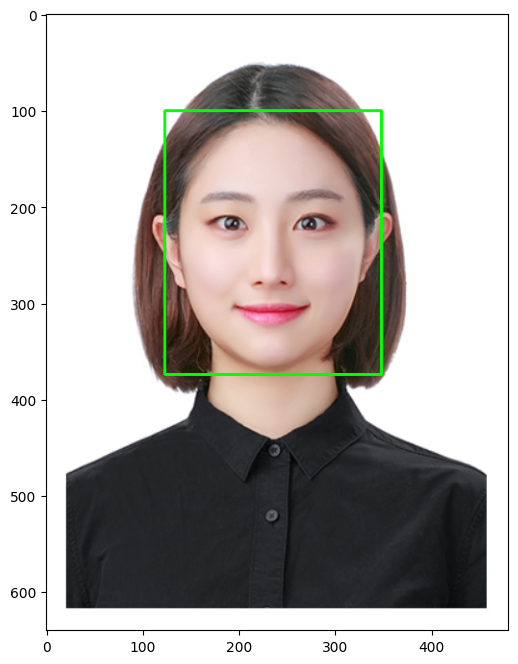

In [6]:
plt.imshow(HSVSegMask(bgr_img0)[0])

생성한 디텍터를 이용하여 제출한 이미지에서 성공적으로 얼굴을 검출하였다.

---

# **2. Embedding**

# **facenet**
* 딥러닝 모델 학습 위해서는 많은 데이터가 필요하지만 사람 얼굴 데이터를 많이 모으기 힘듦
*  그렇다면 사람마다 차별화된 데이터는 어떻게 얻을까?
 
 =>    같은 사람은 벡터 사이의 거리가 가깝게, 다른 사람과는 벡터 사이의 거리가 멀게 하여 서로 다른 사람임을 식별할 수 있도록 </br>

 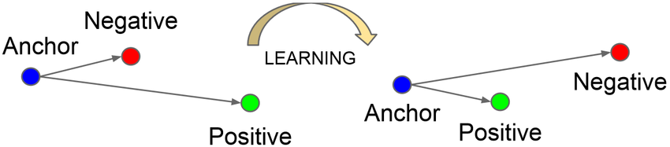

 </br>

 * Triplet loss

    나와 같은 얼굴은 vector 값이 가깝게, 다른 사람과의 vector 거리는 멀게 하도록 loss function을 만듦</br>

    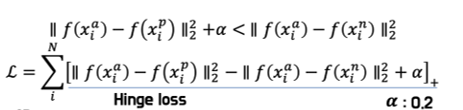

    **f(xa) - f(xPositive) < f(xa) - f(xNegative)**




In [7]:
# rgb image 보여주기 위한 show 함수
def show(img_bgr):
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.show()

내 얼굴 이미지를 가져와 list 생성

In [8]:
# my image
face_path = sorted(glob('/root/images/test_img*.jpg'))
list_img_user = [cv2.resize(cv2.imread(p), None, fx=0.5, fy=0.5) for p in face_path]

for i in range(len(list_img_user)):
    print(list_img_user[i].shape)

(254, 194, 3)
(720, 540, 3)
(720, 540, 3)


list_img_user의 이미지 확인

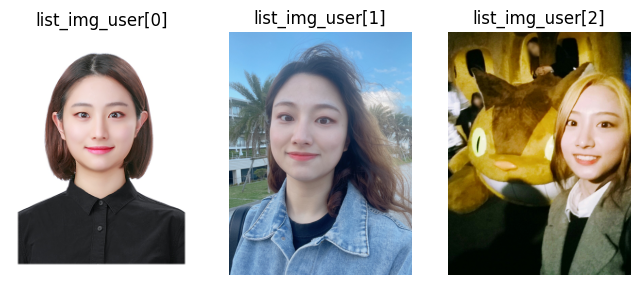

(254, 194, 3) (720, 540, 3) (720, 540, 3)


In [9]:
fig1 = plt.figure()
rows = 1
cols = 3

ax1 = fig1.add_subplot(rows, cols, 1)
ax1.imshow(cv2.cvtColor(list_img_user[0], cv2.COLOR_BGR2RGB))
ax1.set_title('list_img_user[0]')
ax1.axis("off")

ax2 = fig1.add_subplot(rows, cols, 2)
ax2.imshow(cv2.cvtColor(list_img_user[1], cv2.COLOR_BGR2RGB))
ax2.set_title('list_img_user[1]')
ax2.axis("off")

ax3 = fig1.add_subplot(rows, cols, 3)
ax3.imshow(cv2.cvtColor(list_img_user[2], cv2.COLOR_BGR2RGB))
ax3.set_title('list_img_user[2]')
ax3.axis("off")

plt.show()
print(list_img_user[0].shape, list_img_user[1].shape, list_img_user[2].shape)

# 2-1) Dlib을 이용한 embedding

#### Face embedding 으로 내 얼굴 벡터 찾기

먼저 얼굴 검출이 잘 되는지 확인해본다

In [10]:
# dlib의 hog detector 선언 
detector_hog = dlib.get_frontal_face_detector()
rgb_lst = [[], [], []]
for i in range(len(list_img_user)):
    rgb_lst[i] = cv2.cvtColor(list_img_user[i].copy(), cv2.COLOR_BGR2RGB)

    dlib_rects = detector_hog(rgb_lst[i], 1) 
    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()

        cv2.rectangle(rgb_lst[i], (l, t), (r, b), (0, 255, 0), 2, lineType = cv2.LINE_AA)

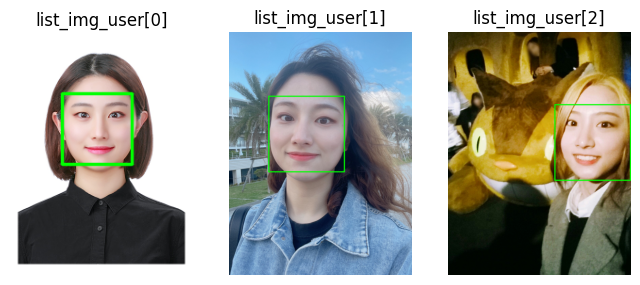

In [11]:
fig2 = plt.figure()
rows = 1
cols = 3

ax1 = fig2.add_subplot(rows, cols, 1)
plt.imshow(rgb_lst[0])
ax1.set_title('list_img_user[0]')
ax1.axis("off")

ax2 = fig2.add_subplot(rows, cols, 2)
plt.imshow(rgb_lst[1])
ax2.set_title('list_img_user[1]')
ax2.axis("off")

ax3 = fig2.add_subplot(rows, cols, 3)
ax3.imshow(rgb_lst[2])
ax3.set_title('list_img_user[2]')
ax3.axis("off")

plt.show()

얼굴이 잘 검출된다

**임베딩 함수**

(1) 128차원의 0벡터를 미리생성한다. 

(2) face_recognition.face_location 함수를 이용하여 얼굴의 위치를 찾는다.

* face_location 함수는 (top, right, bottom, left)을 반환.

(3) 이미지와 bounding box location을 이용하여 128차원의 float vector를 생성한다.




In [12]:
# np 형태의 data db(메모리) 생성
def DlibEmbedding(list_img): 
    
    # 0벡터 미리 생성 
    np_embs = np.zeros((len(list_img), 128))

    for idx, img in enumerate(tqdm(list_img)):
        # 얼굴 위치 찾기
        locations = face_recognition.face_locations(img)

        # 이미지와 bounding box location을 이용하여 128차원의 float vector 생성
        encodings = face_recognition.face_encodings(img, locations)

        if len(encodings) > 0:
            np_embs[idx] = encodings[0]
        else:
            print(idx, 'no face')

    return np_embs

#### 내 얼굴 list에 대한 embedding을 실행

In [13]:
DlibEmbedded = DlibEmbedding(list_img_user)
DlibEmbedded.shape

# [-6.31681681e-02,  3.46095040e-02,  6.58283606e-02,
#  -1.32835969e-01, -1.13626823e-01, -2.84089297e-02,
#       ...               ...              ...

  0%|          | 0/3 [00:00<?, ?it/s]

(3, 128)

#### 내 얼굴 이미지 사이의 거리

In [14]:
dlib_dist_user_user = np.zeros(9).reshape(3, 3)
for i in range(len(DlibEmbedded)):
    dlib_dist_user_user[i] = np.linalg.norm(DlibEmbedded[i] - DlibEmbedded, axis=1)

print(dlib_dist_user_user)

[[0.         0.42623898 0.4003964 ]
 [0.42623898 0.         0.50649119]
 [0.4003964  0.50649119 0.        ]]


0번 이미지 - 1번 이미지 사이 거리: 0.426

1번 이미지 - 2번 이미지 사이 거리: 0.506

2번 이미지 - 0번 이미지 사이 거리: 0.400

**==> dlib을 이용해 detecting한 list_img_user의 얼굴들은 서로 0.4~0.5 정도의 L2norm 거리를 가진다.**

#### 내 얼굴 이미지 사이의 cos similarity

두 벡터 사이의 cos similarity를 구할 수 있는 cos_sim 함수를 정의한다

In [15]:
def cos_sim(A, B):
  return np.dot(A, B)/(np.linalg.norm(A)*np.linalg.norm(B))

list_img_user의 이미지들 사이의 cos similarity를 계산한다

In [16]:
dlib_sim_user_user = np.zeros(3)

for i in range(len(DlibEmbedded)):
    dlib_sim_user_user[i] = cos_sim(DlibEmbedded[i], DlibEmbedded[i-1])

print(dlib_sim_user_user)

[0.9573399  0.95485255 0.93593539]


0번 이미지 - 2번 이미지 사이 cos similarity: 0.957

1번 이미지 - 0번 이미지 사이 cos similarity: 0.955

2번 이미지 - 1번 이미지 사이 cos similarity: 0.936

**==> dlib을 이용해 detecting한 list_img_user의 얼굴들은 서로 0.93~0.95 정도의 cos slmilarty 값을 가진다.**

# 2-2) HSVSegMask를 이용한 embedding

#### 앞서 정의한 HSVSegMask 함수를 이용하여 내 얼굴 벡터 찾기

먼저 얼굴 검출이 잘 되는지 확인해본다

In [17]:
detected = [[], [], []]
for i in range(len(list_img_user)):
    detected[i] = HSVSegMask(list_img_user[i].copy())[0]


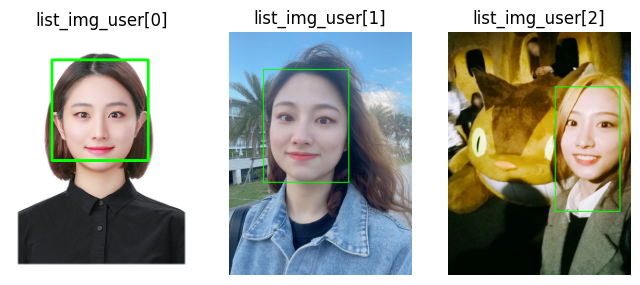

In [18]:
fig3 = plt.figure()
rows = 1
cols = 3

ax1 = fig3.add_subplot(rows, cols, 1)
plt.imshow(detected[0])
ax1.set_title('list_img_user[0]')
ax1.axis("off")

ax2 = fig3.add_subplot(rows, cols, 2)
plt.imshow(detected[1])
ax2.set_title('list_img_user[1]')
ax2.axis("off")

ax3 = fig3.add_subplot(rows, cols, 3)
ax3.imshow(detected[2])
ax3.set_title('list_img_user[2]')
ax3.axis("off")

plt.show()

얼굴이 잘 검출되었다

**임베딩 함수 정의**

(1) 128차원의 0벡터를 미리생성한다. 

(2) HSVSegMask 함수를 이용하여 얼굴의 위치를 찾는다.

* HSVSegMask는 rgb_img, xmin, ymin, width, height 값을 반환

(3) face_encodings 함수는 (top, right, bottom, left)을 파라미터로 받으므로 반환된 HSVSegMask 함수로부터 반환된 값을 변환하여 locations 변수로 지정한다

(4) 이미지와 bounding box location을 이용하여 128차원의 float vector를 생성한다.




In [19]:
# np 형태의 data db(메모리) 생성
def SegMaskEmbedding(list_img): 
    
    # 0벡터 미리 생성 
    np_embs = np.zeros((len(list_img), 128))

    for idx, img in enumerate(tqdm(list_img)):
        # 얼굴 위치 찾기
        _, xmin, ymin, width, height = HSVSegMask(img)

        # face_encodings가 받는 파라미터 형식에 맞추어 locations 변수 지정 
        locations  = [(ymin, xmin + width, ymin + height, xmin)]
        encodings = face_recognition.face_encodings(img, locations)
        if len(encodings) > 0:
            np_embs[idx] = encodings[0]
        else:
            print(idx, 'no face')

    return np_embs

#### 내 얼굴 list에 대한 embedding을 실행

In [20]:
SegMaskEmbedded = SegMaskEmbedding(list_img_user)
SegMaskEmbedded.shape

# [-6.31681681e-02,  3.46095040e-02,  6.58283606e-02,
#  -1.32835969e-01, -1.13626823e-01, -2.84089297e-02,
#       ...               ...              ...

  0%|          | 0/3 [00:00<?, ?it/s]

(3, 128)

#### 내 얼굴 이미지 사이의 거리

In [21]:
SegMask_dist_user_user = np.zeros(9).reshape(3, 3)
for i in range(len(SegMaskEmbedded)):
    SegMask_dist_user_user[i] = np.linalg.norm(SegMaskEmbedded[i] - SegMaskEmbedded, axis=1)

print(SegMask_dist_user_user)

[[0.         0.42005587 0.35916946]
 [0.42005587 0.         0.44796132]
 [0.35916946 0.44796132 0.        ]]


0번 이미지 - 1번 이미지 사이 거리: 0.420

1번 이미지 - 2번 이미지 사이 거리: 0.448

2번 이미지 - 0번 이미지 사이 거리: 0.359

**==> HSVSegMask 함수를 이용하여 detecting한 list_img_user의 얼굴들은 서로 0.4 정도의 L2norm 거리를 가진다.**

#### 내 얼굴 이미지 사이의 cos similarity

list_img_user의 이미지들 사이의 cos similarity를 계산한다

In [22]:
SegMask_sim_user_user = np.zeros(3)

for i in range(len(SegMaskEmbedded)):
    SegMask_sim_user_user[i] = cos_sim(SegMaskEmbedded[i], SegMaskEmbedded[i-1])

print(SegMask_sim_user_user)

[0.96626874 0.95590929 0.94998769]


0번 이미지 - 2번 이미지 사이 cos similarity: 0.966

1번 이미지 - 0번 이미지 사이 cos similarity: 0.956

2번 이미지 - 1번 이미지 사이 cos similarity: 0.950

**==> HSVSegMask 함수를 이용하여 detecting한 list_img_user의 얼굴들은 서로 0.95~0.96 정도의 cos slmilarty 값을 가진다.**


---
## dlib detector 와 color segmentation mask detector 의 결과가 어떻게 다른지 비교하고 둘 중 어떤 detector 를 수정해야할까?



 같은 사람의 얼굴끼리는 더 높은 cos similarity 값을을 가져야 한다.
 
* dlib을 이용하여 detecting한 user 이미지의 유사도 
> [0.9573399  0.95485255 0.93593539]

* HSVSegMask를 이용하여 detecting한 user 이미지의 유사도 
> [0.96626874 0.95590929 0.94998769]

Dlib detector를 사용한 것 보다 HSVSegMask를 사용한 것이 얼굴 이미지들 사이의 유사도가 아주 약간 더 높다. 

Dlib detector를 사용하는 것 보다 HSVSegMask를 사용하는 것이 아주 약간 성능이 더 좋은 것이라 조심스레 추측해 본다. 

확신은 없지만 dlib detector를 수정..해야할 것 같다

---

# **3. 실행 시간 비교**

# 3-1) dlib

In [ ]:
%%time
DlibEmbedded = DlibEmbedding(list_img_user)
np_dist_user_user = np.zeros(9).reshape(3, 3)
for i in range(len(DlibEmbedded)):
    np_dist_user_user[i] = np.linalg.norm(DlibEmbedded[i] - DlibEmbedded, axis=1)

print(np_dist_user_user)

  0%|          | 0/3 [00:00<?, ?it/s]

[[0.         0.42623898 0.4003964 ]
 [0.42623898 0.         0.50649119]
 [0.4003964  0.50649119 0.        ]]
CPU times: user 626 ms, sys: 1.58 ms, total: 628 ms
Wall time: 635 ms


#3-2) HSVSegMask

In [ ]:
%%time
SegMaskEmbedded = SegMaskEmbedding(list_img_user)
SegMask_user_user = np.zeros(9).reshape(3, 3)
for i in range(len(SegMaskEmbedded)):
    SegMask_user_user[i] = np.linalg.norm(SegMaskEmbedded[i] - SegMaskEmbedded, axis=1)

print(SegMask_user_user)

  0%|          | 0/3 [00:00<?, ?it/s]

[[0.         0.42005587 0.35916946]
 [0.42005587 0.         0.44796132]
 [0.35916946 0.44796132 0.        ]]
CPU times: user 71.7 ms, sys: 3.42 ms, total: 75.1 ms
Wall time: 96.9 ms


#### dlib detector의 경우 실행 시간은 635ms, color segmentation mask detector 의 경우 실행 시간은 96.9ms이다.